# Notebook Setup

In [2]:
#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
#MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

## Import Modules

In [3]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import sys
import math
import json
import time
import pandas as pd
import numpy as np
from calendar import monthrange
from datetime import datetime
from io import BytesIO
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Define Local File System Constants

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [5]:
# Define dataset
container = "all-sites-data"
ext = "parquet"
ver = "mvp-v2-knn"
model = "rfr"
train_blob_name = f"{model}-full_2010_2015-train-v-{ver}.{ext}"
val_blob_name = f"{model}-full_2010_2015-val-v-{ver}.{ext}"
test_blob_name = f"{model}-full_2010_2015-test-v-{ver}.{ext}"

In [6]:
# Load splits from Azure
azStorageClient = AzStorageClient(az_cred_file)

train_fs = azStorageClient.downloadBlob2Stream(container, train_blob_name)
train_df = pd.read_parquet(train_fs, engine='pyarrow')

val_fs = azStorageClient.downloadBlob2Stream(container, val_blob_name)
val_df = pd.read_parquet(val_fs, engine='pyarrow')

test_fs = azStorageClient.downloadBlob2Stream(container, test_blob_name)
test_df = pd.read_parquet(test_fs, engine='pyarrow')

In [7]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 'datetime','gap_flag_hour', 'gap_flag_month']

X_train = train_df.drop([target_variable] + drop_cols, axis=1)
y_train = train_df[target_variable]
X_val = val_df.drop([target_variable] + drop_cols, axis=1)
y_val = val_df[target_variable]
X_test = test_df.drop([target_variable] + drop_cols, axis=1)
y_test = test_df[target_variable]

## Train RFR Model w/ best params from v1 tuning (see mvp notebook)

In [8]:
# Using best params from the tuned model in V1
best_params = {}
best_params['n_estimators'] = 50
best_params['max_depth'] = 10
best_params['max_features'] = 'sqrt'

model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.8s finished


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42, verbose=1)

In [9]:
# Save model object
model_save_path_pkl = os.path.join(model_objects_dir, 'rfr_mvp_v2_eng_feats.pkl')
model_save_path_jl = os.path.join(model_objects_dir, 'rfr_mvp_v2_eng_feats.joblib')
if not os.path.exists(model_save_path_pkl):
    print("Saving model in .pkl format")
    joblib.dump(model, model_save_path_pkl)
    
if not os.path.exists(model_save_path_jl):
    print("Saving model in .joblib format")
    joblib.dump(model, model_save_path_jl)

In [10]:
# Re-load saved model
try:
    model_pkl = joblib.load(model_save_path_pkl)
    model_jl = joblib.load(model_save_path_jl)
    print("Loaded both model objects")
except:
    print("unable to load models, make sure object paths are correct and conda env in use")

Loaded both model objects


In [12]:
# Load scaler objects
scaler_v2_obj = '/root/co2-flux-hourly-gpp-modeling/code/src/preprocessing/preproc_objects/scaler_rfr-mvp-v2.joblib'
try:
    scaler_v2 = joblib.load(scaler_v2_obj)
    print("Loaded scaler objects")
except:
    print("unable to load models, make sure object paths are correct and conda env in use")

Loaded scaler objects


## Evaluate RFR on Val & Test Set

In [13]:
# Predict on val/test sets
y_pred_val = model_pkl.predict(X_val)
y_pred_test = model_pkl.predict(X_test)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Val RMSE: {rmse}")
print(f"Val MAE: {mae}")
print(f"Val R2/NSE: {r2}")

# Evaluate predictions - TEST
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"\nTest RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R2/NSE: {r2}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Val RMSE: 3.8783755838976104
Val MAE: 2.2928570390125502
Val R2/NSE: 0.717506956262116


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


## Get performance by IGBP type

In [14]:
# Get categorical feature back from dummies
igbp_cols = [x for x in test_df.columns if 'IGBP_' in x]
test_df['MODIS_IGBP'] = test_df[igbp_cols].idxmax(axis=1)
test_df['MODIS_IGBP'] = test_df['MODIS_IGBP'].apply(lambda x: x.split("_")[-1])

# Subset df
test_trim = test_df[['MODIS_IGBP', 'GPP_NT_VUT_REF']].copy()
test_trim['y_pred'] = y_pred_test

# Get metrics by group
igbp_group_metrics = {}
groups = test_df['MODIS_IGBP'].unique()
for group in groups:
    test_group = test_trim.loc[test_trim['MODIS_IGBP']==group, ].copy()
    
    # Get metrics
    rmse = np.sqrt(mean_squared_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred']))
    mae = mean_absolute_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
    r2 = r2_score(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
    
    # Save to dict
    igbp_group_metrics[group] = {'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 'R2': round(r2, 2)}
    
igbp_metric_df = pd.DataFrame.from_dict(igbp_group_metrics, orient='index')
igbp_metric_df = igbp_metric_df.reset_index().rename(columns={'index': 'MODIS_IGBP'})
igbp_metric_df

,MODIS_IGBP,RMSE,MAE,R2
0,GRA,1.66000,1.07000,0.72000
1,DBF,4.14000,2.33000,0.79000
2,WSA,6.37000,4.24000,0.32000
3,WET,2.75000,1.72000,0.78000
4,ENF,3.81000,2.41000,0.71000
5,CRO,5.29000,2.93000,0.55000
6,OSH,1.25000,0.80000,-0.01000
7,SAV,2.80000,1.62000,0.58000
8,MF,3.08000,2.01000,0.80000


In [15]:
# compute the percentage of the dataset represented by each group
group_sizes = test_trim.groupby('MODIS_IGBP').size()
percentages = group_sizes / len(test_trim) * 100
group_stats = test_trim.groupby('MODIS_IGBP')['GPP_NT_VUT_REF'].agg(['mean', 'var'])
group_stats.columns = ['mean_GPP', 'var_GPP']
group_stats['percent_dataset'] = percentages
group_stats = group_stats.reset_index()

merged_df = pd.merge(group_stats, igbp_metric_df, on='MODIS_IGBP')
merged_df.sort_values('R2', ascending=False, inplace=True)
merged_df

,MODIS_IGBP,mean_GPP,var_GPP,percent_dataset,RMSE,MAE,R2
4,MF,4.04095,47.95594,14.92252,3.08000,2.01000,0.80000
1,DBF,4.34944,80.20588,5.59371,4.14000,2.33000,0.79000
7,WET,2.85502,33.92379,5.56307,2.75000,1.72000,0.78000
3,GRA,1.42292,10.06766,11.85887,1.66000,1.07000,0.72000
2,ENF,4.39118,49.85586,15.86714,3.81000,2.41000,0.71000
6,SAV,1.94456,18.81930,15.20080,2.80000,1.62000,0.58000
0,CRO,4.34011,62.82785,16.14287,5.29000,2.93000,0.55000
8,WSA,2.56527,59.98900,6.92895,6.37000,4.24000,0.32000
5,OSH,0.07602,1.54997,7.92208,1.25000,0.80000,-0.01000


## Feature Importances

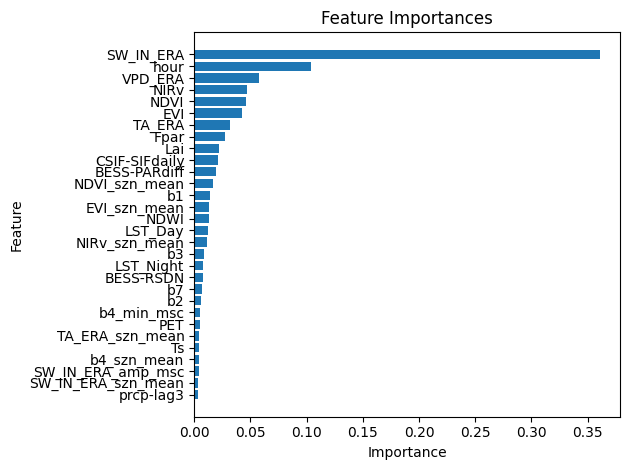

In [16]:
# get the feature importances
importances = pd.Series(model_pkl.feature_importances_, index=X_test.columns).sort_values(ascending=False)

# Visualize
importances_sorted = importances.sort_values(ascending=True)[-30:]

fig, ax = plt.subplots()
ax.barh(importances_sorted.index, importances_sorted.values)
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
fig.tight_layout()
plt.show()

In [17]:
print(importances)

SW_IN_ERA        0.36083
hour             0.10370
VPD_ERA          0.05758
NIRv             0.04676
NDVI             0.04636
                   ...  
MODIS_PFT_ENF    0.00002
MODIS_IGBP_EBF   0.00001
c3c4_unknown     0.00000
MODIS_IGBP_CSH   0.00000
MODIS_IGBP_WET   0.00000
Length: 94, dtype: float64
